# CDK2 protein: 30x4 Cross Validation
## Data load and preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/plotting_metrics.py

In [3]:
%run ./1_Helper_functions.ipynb

In [4]:
protein_name='cdk2'
file_name = '../6_Machine_Learning_Models/df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values

R_a = round(y.sum() / len(y), 4)
print(X.shape)
print(y.sum())
print('Ra =', R_a)

(3466, 402)
415
Ra = 0.1197


In [5]:
def geo_mean_overflow(iterable):
    a = np.log(iterable)
    return np.exp(a.sum()/len(a))

def get_geom_mean_score(df):
    '''Get a dataframe of m*n values and returns a numpy array of euclidean norm scores per row'''
    df_geom_mean = df.apply(geo_mean_overflow, axis=1)
    # keep positive because roc_auc_score in the following line assumes higher is better)
    return df_geom_mean.to_numpy()

In [6]:
geo_mean_overflow(X[1,:] * -1)

8.068775144940052

## Estimators
### ML Classifiers

In [7]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified"}
dclf = DummyClassifier(**hyparams)

In [8]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [9]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 20, 'learning_rate': 0.05, 
           'gamma': 0.01, 'colsample_bytree': 0.5, 'alpha': 0.01}
xgb = XGBClassifier(**hyparams)

In [10]:
# ML Classifier
ml_classifiers = {
    'lr': lr,
    'xgb': xgb,
    'dclf': dclf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [11]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'GEOM': get_geom_mean_score,
    'MIN': get_min_score
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [12]:
estimators = {**ml_classifiers, **cs_functions}

### Evaluation metrics 

In [13]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_12_Ra = {'metric_name': 'ef', 
                    'fraction': R_a, 'method':'normalized'}
            )

# 30x4 CV evaluation

In [14]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def nk_rep_cross_validation_SAVE(filename, **kwargs):
    return nk_rep_cross_validation(**kwargs)

In [15]:
%run ./1_Helper_functions.ipynb


The following procedure performs a P number of assays of K-fold CV.
To track which instances where used for training and testing the `nk_rep_cross_validation()` function also returns the predictions of each model and the split sets, in order to identify which observations were correctly predicted.

- y_preds:
    - Contains the PxK predictions of each method
- splits
    - List that contains PxK tuples with two elements: The train and test indexes.

In [16]:
%%time

n_repeats = 30
n_splits = 4

# **********************
# Perform the evaluation
# **********************
evaluation_name=f'{n_repeats}x{n_splits}cv_GEOM'
cv30x4, y_preds, splits = nk_rep_cross_validation_SAVE(
    filename=f'./cachedir/{evaluation_name}_{protein_name}',
    estimators=estimators, X=X, y=y, metrics=metrics, 
                      n_repeats=n_repeats, n_splits=n_splits,
    y_preds_return=True,
    random_state=42)

# Rename columns 
full_names = ['LR', 'GBT', 'DClf', 'csAVG', 'csGEO', 'csMIN']
new_names = dict(zip(
    [*cv30x4.columns],
    full_names))
cv30x4 = cv30x4.rename(columns=new_names)

# ***************************
# Drop 1NN and csVOTE methods
# ***************************
# cv30x4 = cv30x4.drop(['1-NN', 'csVOTE'], axis=1) # Ommited from the begining
# Update Full names list
full_names = ['LR', 'GBT', 'DClf', 'csAVG', 'csGEO', 'csMIN']

# **********************************
# Extract the individual predictions
# **********************************
# y_preds: Model predictions
# get the test indices
test_sets_idxs = [i[1] for i in splits]

File loaded: ./cachedir/30x4cv_GEOM_cdk2
CPU times: user 80 ms, sys: 14 ms, total: 94 ms
Wall time: 114 ms


In [17]:
%run Friedman_and_Nemenyi_test.ipynb
%load_ext rpy2.ipython

## Friedman Test

In [18]:
cv30x4.to_csv(f'cv30x4_{protein_name}.csv')

In [19]:
# ROC-AUC
metric_name='roc_auc'
df_R = order_df(cv30x4, metric_name).loc[metric_name]

# Descriptive statistics
medians = df_R.median(axis=0).to_frame(name='medians').T
display(medians)

IQRs = df_R.apply(stats.iqr, interpolation = 'midpoint').to_frame(name='IQRs').T
display(IQRs)

# Normality
display(multi_norm_test(cv30x4, metric=metric_name))

roc_normality_res = multi_norm_test_values(cv30x4, metric=metric_name)
# Homocedasticity
display(multi_homovar_test(cv30x4, metric=metric_name))
# Friedman Test
display(friedmanTest(cv30x4.loc[metric_name]))


df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(
                            X, y, metrics[metric_name], 
                            n_reps=30, test_size=0.5, 
                            random_state=42)


,DClf,csMIN,csAVG,csGEO,LR,GBT
medians,0.49819,0.56482,0.63652,0.63712,0.89223,0.90977


,DClf,csMIN,csAVG,csGEO,LR,GBT
IQRs,0.021365,0.044845,0.041765,0.04179,0.018455,0.023535


,LR,GBT,DClf,csAVG,csGEO,csMIN
Normality,1,0,1,0,0,0


,statistic,p
Bartlett,146.308788,8.147960e-30


,chi^2,dof,p_value
Friedman Test,591.514286,5,1.378073e-125


In [20]:
df_R.apply(stats.iqr, interpolation = 'midpoint')

DClf     0.021365
csMIN    0.044845
csAVG    0.041765
csGEO    0.041790
LR       0.018455
GBT      0.023535
dtype: float64

## AUC-ROC

R[write to console]: Registering fonts with R

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘matrixStats’


R[write to console]: The following object is masked from ‘package:dplyr’:

    count


R[write to console]: The following object is masked from ‘package:plyr’:

    count


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

R[write to console]: ── Co

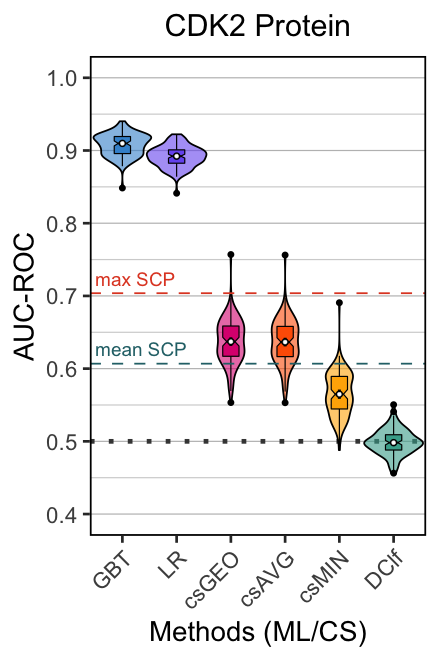

In [21]:
%%R -i full_names -i df_R -i single_mean -i single_max  -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_violin(df_R, cbbPalette, decreasing_order = TRUE, y_min=0.4, y_max=1,
              dot_size=4, scale='area', violin_width=1.1) +
add_ref_values('mean SCP', single_mean, color='#297177', size=2.4, y_add=0.02) + 
add_ref_values('max SCP', single_max, color='#E1492B', size=2.4, y_add=0.02) +
ggtitle('CDK2 Protein')

# Save the picture
protein_name <- 'cdk2'
methodology <- '30x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, 'violin.pdf', sep='_'))
# ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

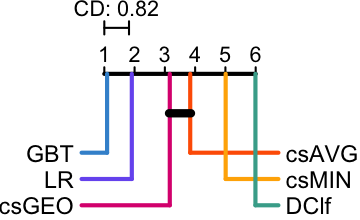

In [22]:
%%R -i df_R -i full_names -w 1.8 -h 1.1 --units in -r 200
library(scmamp)

source('./plotCD.R')
df_R = df_R %>%
    mutate_all(round, 3)

cbbPalette <- hue_pal()(ncol(df_R))
cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

# Save the figure
protein_name <- 'cdk2'
methodology <- '30x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, 'nemenyiCD.pdf', sep='_'))

pdf(filename, 1.8, 1.1)
# plotCD_color(df_R, alpha=0.01, cex=.65, labels.cex=0.7, colPalette=cbbPalette, side_marging=10)
dev.off()

plotCD_color(df_R, alpha=0.01, cex=.65, labels.cex=0.7, colPalette=cbbPalette, side_marging=10)


R[write to console]: 
Attaching package: ‘reshape2’


R[write to console]: The following object is masked from ‘package:tidyr’:

    smiths


R[write to console]: PMCMR is superseded by PMCMRplus and will be no longer maintained. You may wish to install PMCMRplus instead.



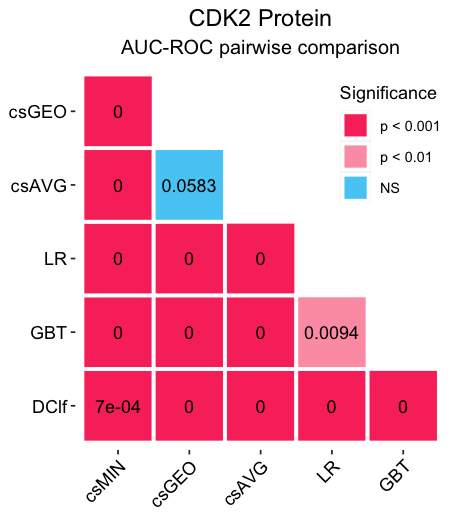

In [23]:
%%R -i df_R -w 3.5 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')
df_R
df_R = df_R %>%
    mutate_all(round, 3)

p = plot_p_vals_heatmap(df_R) +
labs(title='CDK2 Protein', subtitle="AUC-ROC pairwise comparison")

# Save the picture
protein_name <- 'cdk2'
methodology <- '30x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, 'significance.pdf', sep='_'))
# ggsave(filename, plot=p, width=3.5, height= 4)
p

## EF 12% = Ra

In [24]:
# ROC-AUC
metric_name='nef_12_Ra'
df_R = order_df(cv30x4, metric_name).loc[metric_name]

# Descriptive statistics
medians = df_R.median(axis=0).to_frame(name='medians').T
display(medians)

IQRs = df_R.apply(stats.iqr, interpolation = 'midpoint').to_frame(name='IQRs').T
display(IQRs)

# Normality
display(multi_norm_test(cv30x4, metric=metric_name))
nef_normality_res = multi_norm_test_values(cv30x4, metric=metric_name)

# Homocedasticity
display(multi_homovar_test(cv30x4, metric=metric_name))

# Friedman Test
display(friedmanTest(cv30x4.loc[metric_name]))

df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, test_size=0.5, random_state=42)

,DClf,csMIN,csAVG,csGEO,LR,GBT
medians,0.11538,0.20388,0.3301,0.3301,0.56731,0.64423


,DClf,csMIN,csAVG,csGEO,LR,GBT
IQRs,0.053115,0.04238,0.05769,0.05769,0.03846,0.05452


,LR,GBT,DClf,csAVG,csGEO,csMIN
Normality,1,0,1,0,0,1


,statistic,p
Bartlett,9.840953,0.079869


,chi^2,dof,p_value
Friedman Test,577.72619,5,1.312221e-122


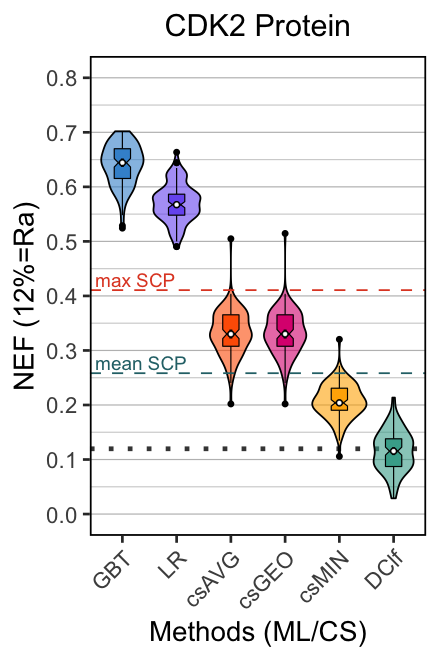

In [25]:
%%R -i full_names -i df_R -i R_a -i single_mean -i single_max  -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_violin(df_R, cbbPalette, decreasing_order = TRUE, y_min=0.0, y_max=0.8,
              dot_size=4, scale='area', violin_width=1., base_h_line=R_a,
               y_label='NEF (12%=Ra)') +
add_ref_values('mean SCP', single_mean, color='#297177', size=2.4, y_add=0.02) + 
add_ref_values('max SCP', single_max, color='#E1492B', size=2.4, y_add=0.02) +
ggtitle('CDK2 Protein')

# Save the picture
protein_name <- 'cdk2'
methodology <- '30x4CV'
metric <- 'NEF'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, 'violin.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

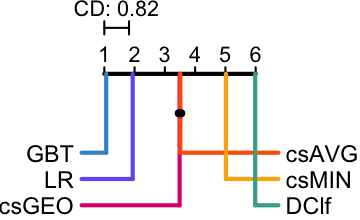

In [26]:
%%R -i df_R -i full_names -w 1.8 -h 1.1 --units in -r 200
library(scmamp)

source('./plotCD.R')
df_R = df_R %>%
    mutate_all(round, 3)

cbbPalette <- hue_pal()(ncol(df_R))
cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

# Save the figure
protein_name <- 'cdk2'
methodology <- '30x4CV'
metric <- 'NEF'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, 'nemenyiCD.pdf', sep='_'))

pdf(filename, 1.8, 1.1)
# plotCD_color(df_R, alpha=0.01, cex=.65, labels.cex=0.7, colPalette=cbbPalette, side_marging=10)
dev.off()

plotCD_color(df_R, alpha=0.01, cex=.65, labels.cex=0.7, colPalette=cbbPalette, side_marging=10)

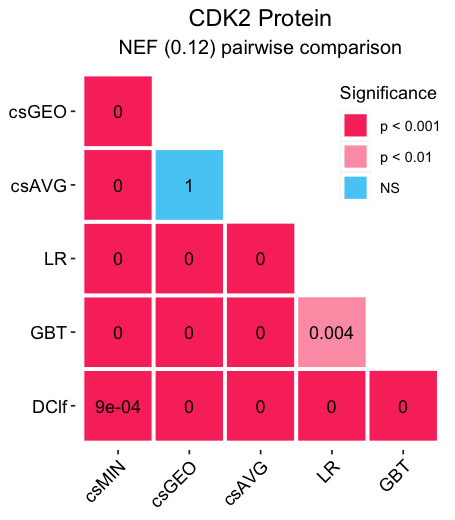

In [27]:
%%R -i df_R -w 3.5 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')
df_R = df_R %>%
    mutate_all(round, 3)

p = plot_p_vals_heatmap(df_R) +
labs(title='CDK2 Protein', subtitle="NEF (0.12) pairwise comparison")

# Save the picture
protein_name <- 'cdk2'
methodology <- '30x4CV'
metric <- 'NEF'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, 'significance.pdf', sep='_'))
# ggsave(filename, plot=p, width=3.5, height= 4)
p

## Normalization test Results

In [28]:
# Normality test results of ROC and NEF metrics
print(get_latex_norm([roc_normality_res, nef_normality_res], 
                     names=['AUC-ROC', 'NEF']).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
    &         &     LR &    GBT &   DClf &  csAVG &  csGEO &  csMIN \\
\midrule
AUC-ROC & W-statistic &  0.987 &  0.971 &  0.993 &  0.978 &  0.977 &  0.964 \\
    & p-value &  0.321 &  0.011 &  0.799 &  0.044 &  0.041 &  0.003 \\
NEF & W-statistic &  0.989 &  0.967 &  0.990 &  0.962 &  0.956 &  0.983 \\
    & p-value &  0.429 &  0.004 &  0.503 &  0.002 &  0.001 &  0.130 \\
\bottomrule
\end{tabular}



### Mauchly test for sphericity

This analysis was carried out using R =>
File `./ANOVA_asumptions_cdk2.R`

In [29]:
import pingouin 

In [30]:
cv30x4_roc = cv30x4.loc['roc_auc']
cv30x4_nef = cv30x4.loc['nef_12_Ra']

In the library `pingouin` at https://github.com/raphaelvallat/pingouin/blob/master/pingouin/distribution.py
the author ommit the use of love eigenvalues. This gives a different result from those obtainded using R libraries.

In [31]:
data = cv30x4_roc
n, k = data.shape
d = k - 1

S = data.cov().to_numpy()  # NumPy, otherwise S.mean() != grandmean
S_pop = S - S.mean(0)[:, None] - S.mean(1)[None, :] + S.mean()
eig = np.linalg.eigvalsh(S_pop)[1:]
# eig = eig[eig > 0.0000001]  # Additional check to remove very low eig
W = np.product(eig) / (eig.sum() / d)**d
logW = np.log(W)
W

1.6363508857315513e-05

In [32]:
roc_rm_anova = pingouin.rm_anova(cv30x4_roc, 
        correction=True)

roc_rm_anova

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,Within,5,595,9833.072721,0.0,5.840740e-192,0.988043,0.333711,True,9.649973e+14,1.0


In [33]:
pingouin.sphericity(cv30x4_nef)

SpherResults(spher=True, W=19278091437.36705, chi2=-2773.1897336516845, dof=14, pval=1.0)

# Y-randomization test

In [34]:
%%time 

n_repeats = 30
n_splits = 4

chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
chi_results = {}
evaluation_name = f'y_scrambling_reps_{n_repeats}x{n_splits}CV_geom'

for chi in chi_fractions:
    filename = f'./cachedir/{evaluation_name}_{protein_name}_chi-{chi}'
    result = nk_rep_cross_validation_scrambling(filename=filename, 
                             random_chi=chi, estimators=estimators, 
                             X=X, y=y, metrics=metrics, 
                             n_repeats=n_repeats, n_splits=n_splits)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result
    

File loaded: ./cachedir/y_scrambling_reps_30x4CV_geom_cdk2_chi-1
Fraction chi=1 finished.
File loaded: ./cachedir/y_scrambling_reps_30x4CV_geom_cdk2_chi-0.75
Fraction chi=0.75 finished.
File loaded: ./cachedir/y_scrambling_reps_30x4CV_geom_cdk2_chi-0.5
Fraction chi=0.5 finished.
File loaded: ./cachedir/y_scrambling_reps_30x4CV_geom_cdk2_chi-0.25
Fraction chi=0.25 finished.
File loaded: ./cachedir/y_scrambling_reps_30x4CV_geom_cdk2_chi-0.0
Fraction chi=0.0 finished.
CPU times: user 27.2 ms, sys: 8.64 ms, total: 35.9 ms
Wall time: 38.9 ms


## AUC-ROC

In [35]:
df_y_random = get_group_stats(chi_results, metric_name='roc_auc')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

In [36]:
full_names

['LR', 'GBT', 'DClf', 'csAVG', 'csGEO', 'csMIN']

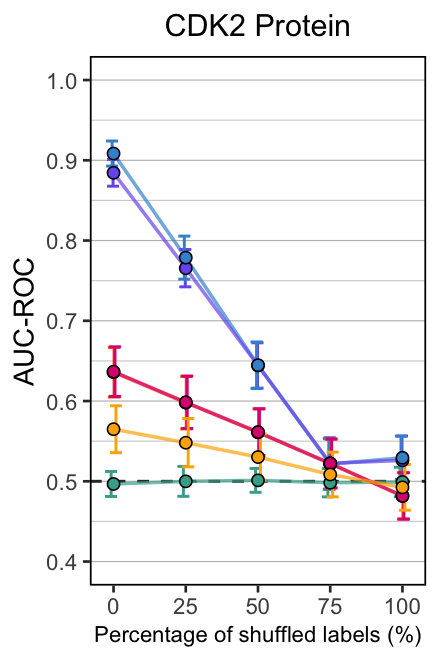

In [37]:
%%R -i df_y_random -i full_names -i df_R -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_lines(df_y_random, cbbPalette, point_size=1.8, line_size=0.6, switch_x=F,
           error_size=0.5, error_dodge=2, error_width=25) +
ggtitle('CDK2 Protein')

# Save the picture
protein_name <- 'cdk2'
methodology <- 'y-scramb-10x4CV'
metric <- 'AUC-ROC'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
# ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

## EF 12% 

In [38]:
df_y_random = get_group_stats(chi_results, metric_name='nef_12_Ra')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

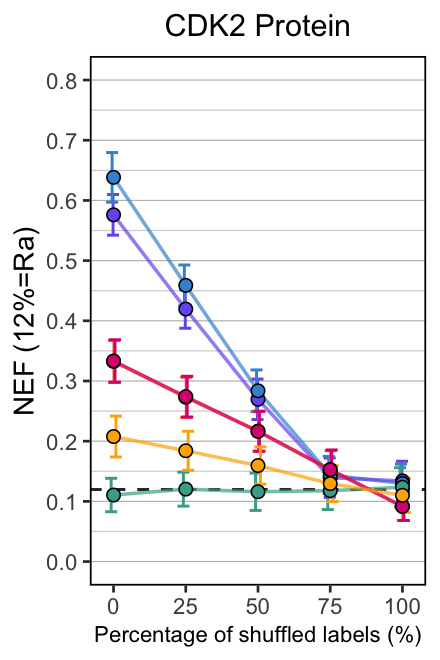

In [39]:
%%R -i df_y_random -i full_names -i df_R -i R_a -w 2.2 -h 3.3 --units in -r 200
 
source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_lines(df_y_random, cbbPalette, point_size=2., line_size=0.6,
           error_size=0.5, error_dodge=2, error_width=25, switch_x=F,
           y_min=0, y_max=0.8, base_h_line=R_a, y_label='NEF (12%=Ra)') +
ggtitle('CDK2 Protein')

# Save the picture
protein_name <- 'cdk2'
methodology <- 'y-scramb-10x4CV'
metric <- 'NEF'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
# ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

# y-rand RFE confs

In [48]:
# Open RFE_estimator
dataset = 'MERGED'
model_name = 'XGB_tree'
split = 'random'
# filename = f'../6_Machine_Learning_Models/ml_models/RFECV_selector_{model_name}_{dataset}_{split}_split.joblib'
filename = f'./rfe_selectors/RFE_xgb_{protein_name}.joblib'
# RFE selector LogReg Random split
rfe_selector = joblib.load(filename)
rfe_selector.ranking_
df_ranks = pd.DataFrame({'pdb_id': X_merged_dksc.columns, 'rfe_ranking': rfe_selector.ranking_})
df_ranks = df_ranks.sort_values('rfe_ranking')

In [49]:
top_16_idx = df_ranks['pdb_id'][:16].index
top_16_idx

Int64Index([303, 139, 293, 311, 122, 376, 126, 203, 179, 373, 153, 382, 323,
            319, 354, 219],
           dtype='int64')

In [55]:
%%time 

# y-randomization using the best 16 features

X_16 = X[:, top_16_idx]

n_repeats = 30
n_splits = 4

chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
chi_results = {}
evaluation_name = f'y_scrambling_reps_{n_repeats}x{n_splits}CV_geom_TOP_16_CONFS'

for chi in chi_fractions:
    filename = f'./cachedir/{evaluation_name}_{protein_name}_chi-{chi}'
    result = nk_rep_cross_validation_scrambling(filename=filename, 
                             random_chi=chi, estimators=estimators, 
                             X=X_16, y=y, metrics=metrics, 
                             n_repeats=n_repeats, n_splits=n_splits)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result
    

File loaded: ./cachedir/y_scrambling_reps_30x4CV_geom_TOP_16_CONFS_cdk2_chi-1
Fraction chi=1 finished.
File loaded: ./cachedir/y_scrambling_reps_30x4CV_geom_TOP_16_CONFS_cdk2_chi-0.75
Fraction chi=0.75 finished.
File loaded: ./cachedir/y_scrambling_reps_30x4CV_geom_TOP_16_CONFS_cdk2_chi-0.5
Fraction chi=0.5 finished.
File loaded: ./cachedir/y_scrambling_reps_30x4CV_geom_TOP_16_CONFS_cdk2_chi-0.25
Fraction chi=0.25 finished.
File loaded: ./cachedir/y_scrambling_reps_30x4CV_geom_TOP_16_CONFS_cdk2_chi-0.0
Fraction chi=0.0 finished.
CPU times: user 16.3 ms, sys: 4.73 ms, total: 21 ms
Wall time: 19.7 ms


## ROC top 16

In [56]:
df_y_random = get_group_stats(chi_results, metric_name='roc_auc')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

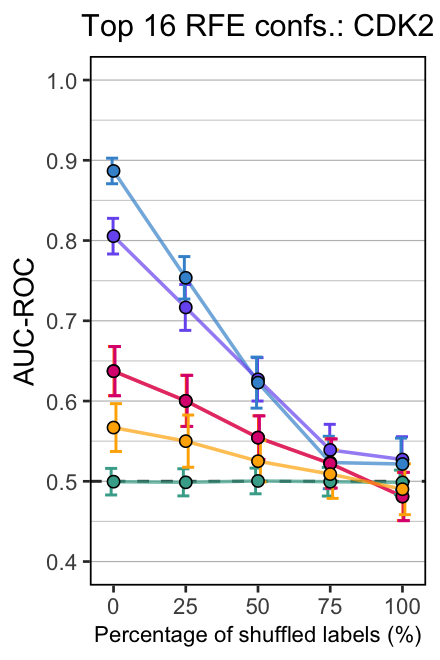

In [57]:
%%R -i df_y_random -i full_names -i df_R -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_lines(df_y_random, cbbPalette, point_size=1.8, line_size=0.6, switch_x=F,
           error_size=0.5, error_dodge=2, error_width=25) +
ggtitle('Top 16 RFE confs.: CDK2')

# Save the picture
protein_name <- 'cdk2'
methodology <- 'y-scramb-10x4CV'
metric <- 'AUC-ROC'
filename <- paste0('images/cdk2/top16RFE_', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

## NEF top 16

In [58]:
df_y_random = get_group_stats(chi_results, metric_name='nef_12_Ra')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

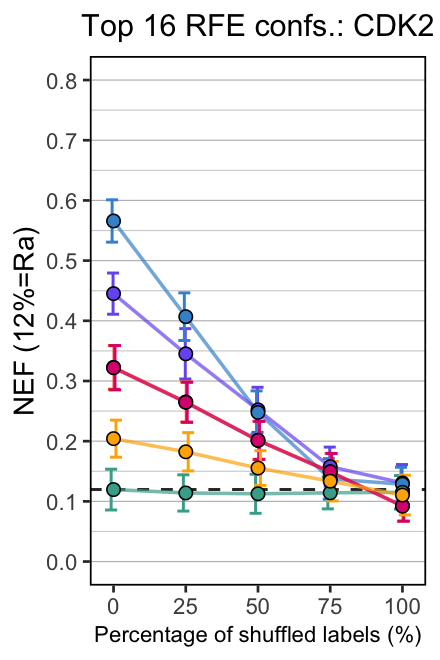

In [59]:
%%R -i df_y_random -i full_names -i df_R -i R_a -w 2.2 -h 3.3 --units in -r 200
 
source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_lines(df_y_random, cbbPalette, point_size=2., line_size=0.6,
           error_size=0.5, error_dodge=2, error_width=25, switch_x=F,
           y_min=0, y_max=0.8, base_h_line=R_a, y_label='NEF (12%=Ra)') +
ggtitle('Top 16 RFE confs.: CDK2')

# Save the picture
protein_name <- 'cdk2'
methodology <- 'y-scramb-10x4CV'
metric <- 'NEF'
filename <- paste0('images/cdk2/top16RFE_', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

## Kruskal-Walist test

In [57]:
# Get a dataframe, long format, with all the results
vs_methods = chi_results['chi_1'].columns
# ROC-AUC
metric = 'roc_auc'
dataframes = [get_model_y_rand_results(method, metric) 
              for method in vs_methods]
all_df_results_roc = pd.concat(dataframes, axis=0, keys=vs_methods)

# NEF
metric = 'nef_12_Ra'
dataframes = [get_model_y_rand_results(method, metric) 
              for method in vs_methods]
all_df_results_nef = pd.concat(dataframes, axis=0, keys=vs_methods)

# Merge the results
all_df_results = pd.concat([all_df_results_roc, 
                            all_df_results_nef], 
                  keys=('auc_roc', 'nef'))

all_df_results.rename(index={'cs_GEOM':'cs_GEO'},inplace=True)
all_df_results.to_csv(f'./yRand_30x4cv_{protein_name}.csv')

## Pairwise Plots

In [44]:
df_R = sp.posthoc_mannwhitney(a = df_y_res, 
                       val_col = 'score', 
                       group_col='Method', 
                       alternative='two-sided').round(3)

/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


NameError: name 'df_y_res' is not defined

In [ ]:
%%R -i df_R -w 3.5 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

p = plot_p_vals_heatmap_kruskal(df_R) +
    labs(title='CDK2', subtitle="NEF (0.12) pairwise comparison")

# # # Save the picture
# # protein_name <- 'cdk2'
# # methodology <- '30x4CV'
# # metric <- 'NEF'
# # filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, 'significance.pdf', sep='_'))
# # ggsave(filename, plot=p, width=3.5, height= 4)
p


# Permutation Test
From [sklearn](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_permutation_test_for_classification.html#sphx-glr-auto-examples-feature-selection-plot-permutation-test-for-classification-py)

In [ ]:
%%time

from sklearn.model_selection \
    import StratifiedKFold, permutation_test_score

cv = StratifiedKFold(4, shuffle=True, 
                     random_state=42)

score, perm_scores, pvalues = permutation_test_score(
    lr,
    X,
    y,
    scoring='roc_auc',
    cv=cv, n_permutations=20
)

In [ ]:
fig, ax = plt.subplots()

ax.hist(perm_scores, bins=20, density=True)
ax.axvline(score, ls='--', color='r')
score_label = (f"Score on original\ndata: {score:.2f}\n"
               f"(p-value: {pvalues:.3f})")
ax.text(0.7, 30, score_label, fontsize=12)
ax.set_title('LR: Permutation Test')
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")